# SciPy analog filter design
Last update: 27 Aug 2022  
  
This notebook describes the general use of filter functions in the [SciPy](https://docs.scipy.org/doc/scipy/reference/signal.html) library which can be used to design analog filters. Filters are one of the basic building blocks of signal processing. In general terms, filters used for signal processing can be divided into two groups, analog and digital filters. Analog filters, the topic of this notebook, are filters which can be described with linear differential equations and implemented in circuits which operate on continuously varying signals. A digital filter is a system that performs operations on a sampled, discrete-time signal with numerical operations.

The first part of this notebook uses SciPy functions to calculate analog filter polynominals based on the classical [Butterworth](https://en.wikipedia.org/wiki/Butterworth_filter), [Chebyshev](https://en.wikipedia.org/wiki/Chebyshev_filter), [Elliptic](https://en.wikipedia.org/wiki/Elliptic_filter) and [Bessel](https://en.wikipedia.org/wiki/Bessel_filter) filters. The last section of this notebook walks through a Butterworth filter design and Caouer synthesis of an LC ladder type filter. 

The Analog filter design can be approached in two ways, by synthysis or by cookbook methods. The SciPy filter design functions fall into the cookbook method of design and stop at circuit realization. SciPy has filter functions that generate the coefficients of the polynomials for [Butterworth](https://en.wikipedia.org/wiki/Butterworth_filter), [Chebyshev](https://en.wikipedia.org/wiki/Chebyshev_filter), [Elliptic](https://en.wikipedia.org/wiki/Elliptic_filter) and [Bessel](https://en.wikipedia.org/wiki/Bessel_filter) type filters. And for each type filter, lowpass, highpass, bandpass and bandstop can be specified. SciPy also has filter functions that can evaluate the frequnecy and transient response of the filters. For the Butterworth, Chebyshev and elliptic type filters there are functions which can estimate the filter order required to met passband or stopband ripple and attenuation specifications. However there is no Bessel order specification function included in the SciPy libraries.

There are several important filter types such as [Gaussian](https://en.wikipedia.org/wiki/Gaussian_filter), [Optimum "L" filter](https://en.wikipedia.org/wiki/Optimum_%22L%22_filter) and [Linkwitz–Riley filter](https://en.wikipedia.org/wiki/Linkwitz%E2%80%93Riley_filter) that are not included in the SciPy signal processing module.

The SciPy filter functions provide the electrical engineer with the polyimomional coefficients for the filter transfer function. Taking the filter polyimonial coefficients and designing an analog filter circuit is not within the scope of what SciPy provides. At this point in the filter design process, the engineer can implement some types of filter networks by using design tables. 

Example calculations are provided below for synthesis of a low pass filter. In the example, I walk through the calculations for filter [synthesis](https://en.wikipedia.org/wiki/Network_synthesis#cite_ref-31) directly from the transfer function of a Butterworth lowpass filter. Butterworth lowpass filters are all pole filters with unity numerator in the transfer function which allows the driving point impedance to easly be found and the filter synthesis is accomplished by expanding the $Z_{11}$ with partial fraction expansion.

**Notes on filter synthesis**  
Currently when designs require a ladder prototype, a designer completes the task with the aid of tables. The complex numerical methods involved in generating tables are far from general. Transfer functions with zeros require very complex and filter specific algorithms. The most common approach, Cauer's algorithm takes advantage of a particular filter's properties. Each filter approximation technique needs its own specific algorithm [1]. For transfer functions with zeros, Cauer's approach produces only one circuit implementation, where many are possible. For transfer functions without zeros, such as Butterworth, Chevbyshev and Bessel-Thompson type filters, determining element values involves the classical continued fraction expansion of the input impedance.

Reference  
1. R. D. Koller and B. M. Wilamowski, A ladder prototype synthesis algorithm, Proceedings of the 35th Midwest Symposium on Circuits and Systems, 1992
2. Electronic Filter Design Handbook, 3rd Edition, Arthur B. Williams, Fred J. Taylor, McGraw Hill, 1995

Related information DSP references:   
- https://pysdr.org/index.html  
- https://medium.datadriveninvestor.com/designing-filters-made-easy-using-python-9c44d9064f94

In [486]:
import numpy as np
from scipy import signal
from sympy import *
import matplotlib.pyplot as plt
init_printing()

## Lowpass filter specification
The SciPy functions used below can be used to find the order of the filter required based on the passband frequency, stopband frequency and allowable ripple or attenuation.

SciPy has four functions that return the order of the filter satisfying the users filter specifications, which are in the buttord, cheb1ord, cheb2ord and ellipord. Depending on the type of filter wanted, uncomment the particular function.

In [487]:
fp = 5e3 # passband edge frequency, Hz
gpass = 3 # The maximum loss in the passband (dB)

fs = 10e3 # stopband edge frequency, Hz
gstop = 40 # The minimum attenuation in the stopband (dB)

# uncomment filter type to use
N, Wn = signal.buttord(fp*2*np.pi, fs*2*np.pi, gpass, gstop,analog=True)
#N, Wn = signal.cheb1ord(fp*2*np.pi, fs*2*np.pi, gpass, gstop,analog=True)
#N, Wn = signal.cheb2ord(fp*2*np.pi, fs*2*np.pi, gpass, gstop,analog=True)
#N, Wn = signal.ellipord(fp*2*np.pi, fs*2*np.pi, gpass, gstop,analog=True)

print('order = {:.0f}, frequency = {:.2f} rad/sec'.format(N,Wn))

order = 7, frequency = 31426.58 rad/sec


### Find filter coefficients
Uncomment the line depending on the type of filter desired. The functions return the numerator (b) and denominator (a), polynomials.

In [488]:
system_lp = signal.butter(N, Wn, btype='lowpass', output='ba', analog=True)
#system_lp = signal.cheby1(N, gpass, Wn, btype='lowpass', output='ba', analog=True)
#system_lp = signal.cheby2(N, gstop, Wn, btype='lowpass', output='ba', analog=True)
#system_lp = signal.ellip(N, gpass, gstop, Wn, btype='lowpass', output='ba', analog=True)
#system_lp = signal.bessel(N, Wn, btype='lowpass', output='ba', analog=True, norm='mag')

### plot filter specification limits
The grey areas are the keep out areas specified above.

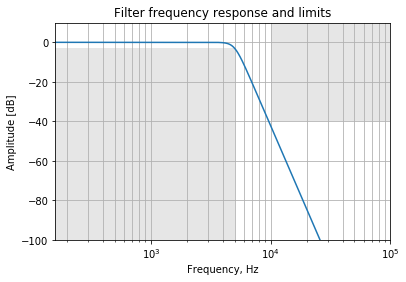

In [489]:
b, a = system_lp
w, h = signal.freqs(b, a, 2000) # Compute frequency response of analog filter
plt.semilogx(w/(2*np.pi), 20 * np.log10(abs(h)))
plt.title('Filter frequency response and limits')
plt.xlabel('Frequency, Hz')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')

plt.fill([0, fp,  fp,  0], [-gpass, -gpass, -100, -100], '0.9', lw=0) # passband
plt.fill([fs, fs, 100e9, 100e9], [-gstop, 100, 100, -gstop], '0.9', lw=0) # stopband
plt.xlim((w[0]/(2*np.pi),100e3))
plt.ylim((-100,10))
plt.show()

### plot poles and zeros

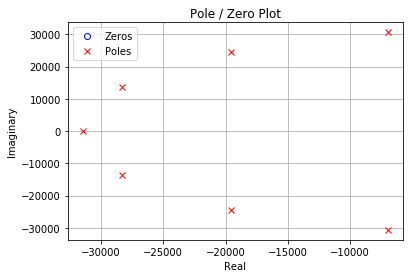

k = 30274733497480892041442126462976.0


In [490]:
z, p, k = signal.tf2zpk(system_lp[0],system_lp[1])

plt.plot(np.real(z), np.imag(z), 'ob', markerfacecolor='none')
plt.plot(np.real(p), np.imag(p), 'xr')
plt.legend(['Zeros', 'Poles'], loc=2)
plt.title('Pole / Zero Plot')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.show()
print('k = {:.1f}'.format(k))

### Plot the Bode magnitude and phase data
Use the SciPy function [bode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bode.html) to plot the magnitude and phase of the filter.

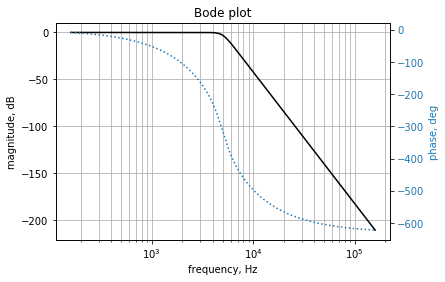

In [491]:
#x = np.linspace(10*2*np.pi, 10e3*2*np.pi, 1000, endpoint=True)
w, mag, phase = signal.bode(system_lp, w=w)

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-k')    # Bode magnitude plot

ax1.tick_params(axis='y')
plt.grid(which='both', axis='both')

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(w/(2*np.pi), phase,':',color=color)  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Bode plot')
plt.show()

### Plot the impulse and step response
Use the SciPy functions [impulse2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.impulse2.html) and [step2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.step2.html) to plot the impulse and step response of the system.

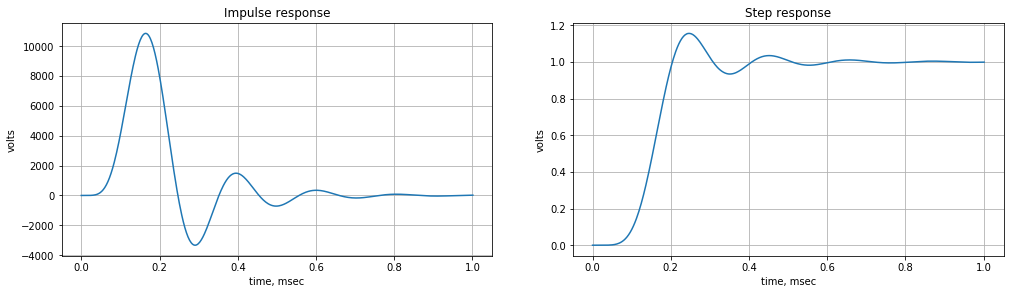

In [492]:
# figsize() function to adjust the size
plt.subplots(figsize=(15, 5))

# using subplot function and creating
# plot one
plt.subplot(1, 2, 1)

# impulse response
t, y = signal.impulse2(system_lp,N=500)
plt.plot(t/1e-3, y)
plt.title('Impulse response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# using subplot function and creating plot two
plt.subplot(1, 2, 2)

t, y = signal.step2(system_lp,N=500)
plt.plot(t/1e-3, y)
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# space between the plots
plt.tight_layout(4)

# show plot
plt.show()

#### Plot the group delay.
The following python code calculates and plots [group delay](https://en.wikipedia.org/wiki/Group_delay_and_phase_delay#). Frequency components of a signal are delayed when passed through a circuit and the signal delay will be different for the various frequencies unless the circuit has the property of being linear phase. The delay variation means that signals consisting of multiple frequency components will suffer distortion because these components are not delayed by the same amount of time at the output of the device.

Group delay: $\tau _{g}(\omega )=-\frac  {d\phi (\omega )}{d\omega }$

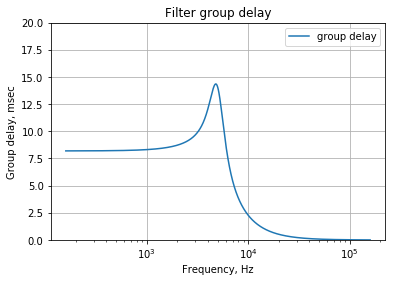

In [493]:
plt.title('Filter group delay')
plt.semilogx(w/(2*np.pi), -np.gradient(phase)/np.gradient(w)/1e-3,'-',label='group delay')
#plt.semilogx(w/(2*np.pi), -np.gradient(phase)/w/1e-3,'-',label='phase delay')
plt.ylabel('Group delay, msec')
plt.xlabel('Frequency, Hz')
plt.ylim((0,20))
plt.legend()
plt.grid()
plt.show()

## Highpass filter specification
Using the same filter order selection function above, set the passband frequency limit above the stopband frequency limit.

In [494]:
fp = 10e3 # passband edge frequency, Hz
gpass = 3 # The maximum loss in the passband (dB)

fs = 5e3 # stopband edge frequency, Hz
gstop = 40 # The minimum attenuation in the stopband (dB)

# uncomment filter type to use
#N, Wn = signal.buttord(fp*2*np.pi, fs*2*np.pi, gpass, gstop,analog=True)
N, Wn = signal.cheb1ord(fp*2*np.pi, fs*2*np.pi, gpass, gstop,analog=True)
#N, Wn = signal.cheb2ord(fp*2*np.pi, fs*2*np.pi, gpass, gstop,analog=True)
#N, Wn = signal.ellipord(fp*2*np.pi, fs*2*np.pi, gpass, gstop,analog=True)

print('order = {:.0f}, frequency = {:.2f} rad/sec'.format(N,Wn))

order = 5, frequency = 62831.85 rad/sec


### Find filter coefficients
Uncomment the line depending on the type of filter desired. The functions return the numerator (b) and denominator (a), polynomials.

In [495]:
#system_hp = signal.butter(N, Wn, btype='highpass', output='ba', analog=True)
system_hp = signal.cheby1(N, gpass, Wn, btype='highpass', output='ba', analog=True)
#system_hp = signal.cheby2(N, gstop, Wn, btype='highpass', output='ba', analog=True)
#system_hp = signal.ellip(N, gpass, gstop, Wn, btype='highpass', output='ba', analog=True)
#system_hp = signal.bessel(N, Wn, btype='highpass', output='ba', analog=True, norm='mag')

### plot filter specification limits
The grey areas are the keep out areas specified above.

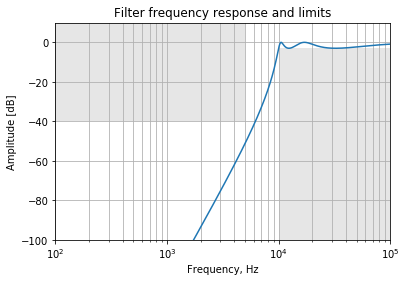

In [496]:
b, a = system_hp
w, h = signal.freqs(b, a, 2000) # Compute frequency response of analog filter
plt.semilogx(w/(2*np.pi), 20 * np.log10(abs(h)))
plt.title('Filter frequency response and limits')
plt.xlabel('Frequency, Hz')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')

plt.fill([100e9, fp,  fp,  100e9], [-gpass, -gpass, -100, -100], '0.9', lw=0) # passband
plt.fill([fs, fs, 0, 0], [-gstop, 100, 100, -gstop], '0.9', lw=0) # stopband
plt.xlim((100,100e3))
plt.ylim((-100,10))
plt.show()

### plot poles and zeros

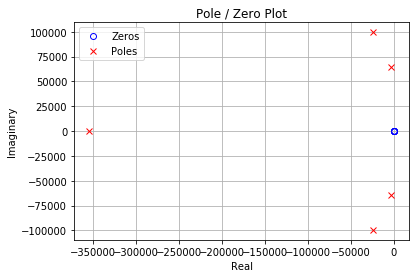

In [497]:
z, p, k = signal.tf2zpk(system_hp[0],system_hp[1])

plt.plot(np.real(z), np.imag(z), 'ob', markerfacecolor='none')
plt.plot(np.real(p), np.imag(p), 'xr')
plt.legend(['Zeros', 'Poles'], loc=2)
plt.title('Pole / Zero Plot')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.show()

### Plot the Bode magnitude and phase data
Use the SciPy function [bode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bode.html) to plot the magnitude and phase of the filter.

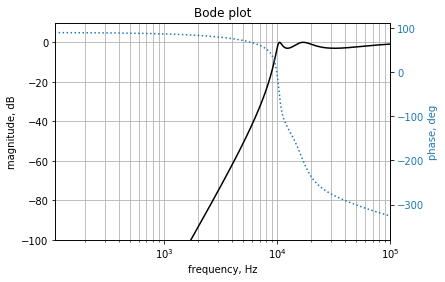

In [498]:
#x = np.linspace(10*2*np.pi, 10e3*2*np.pi, 1000, endpoint=True)
w, mag, phase = signal.bode(system_hp, w=w)

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-k')    # Bode magnitude plot

ax1.tick_params(axis='y')
plt.grid(which='both', axis='both')
ax1.set_xlim((110,100e3))
ax1.set_ylim((-100,10))

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(w/(2*np.pi), phase,':',color=color)  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Bode plot')
plt.show()

### Plot the impulse and step response
Use the SciPy functions [impulse2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.impulse2.html) and [step2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.step2.html) to plot the impulse and step response of the system.

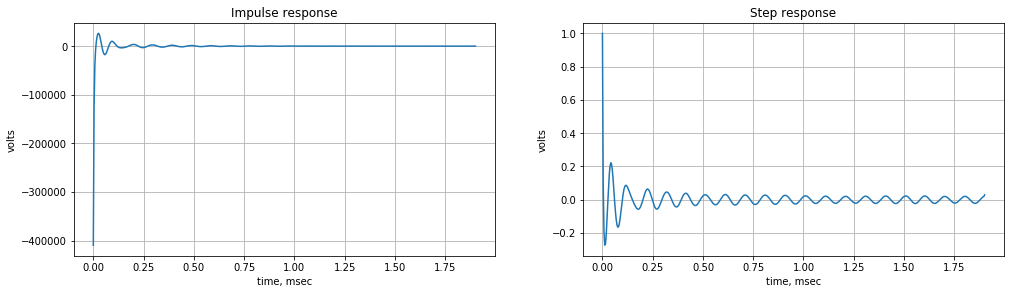

In [499]:
# figsize() function to adjust the size
plt.subplots(figsize=(15, 5))

# using subplot function and creating
# plot one
plt.subplot(1, 2, 1)

# impulse response
t, y = signal.impulse2(system_hp,N=500)
plt.plot(t/1e-3, y)
plt.title('Impulse response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# using subplot function and creating plot two
plt.subplot(1, 2, 2)

t, y = signal.step2(system_hp,N=500)
plt.plot(t/1e-3, y)
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# space between the plots
plt.tight_layout(4)

# show plot
plt.show()

#### Plot the group delay.
The following python code calculates and plots [group delay](https://en.wikipedia.org/wiki/Group_delay_and_phase_delay#). Frequency components of a signal are delayed when passed through a circuit and the signal delay will be different for the various frequencies unless the circuit has the property of being linear phase. The delay variation means that signals consisting of multiple frequency components will suffer distortion because these components are not delayed by the same amount of time at the output of the device.

Group delay: $\tau _{g}(\omega )=-\frac  {d\phi (\omega )}{d\omega }$

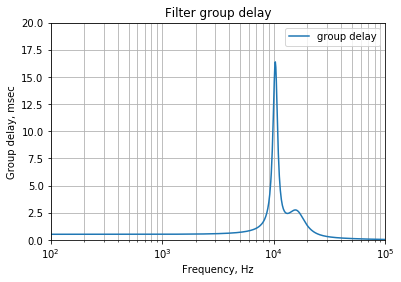

In [500]:
plt.title('Filter group delay')
plt.semilogx(w/(2*np.pi), -np.gradient(phase)/np.gradient(w)/1e-3,'-',label='group delay')
#plt.semilogx(w/(2*np.pi), -np.gradient(phase)/w/1e-3,'-',label='phase delay')
plt.xlim((100,100e3))
plt.ylim((0,20))
plt.ylabel('Group delay, msec')
plt.xlabel('Frequency, Hz')
plt.legend()
plt.grid(which='both', axis='both')
plt.show()

## Bandpass filter specification
Using the same filter order selection function above, set the passband frequency range as a two element array of band edge frequencies. Set the stopband frequencies as a two element array of band edge frequencies.


In [501]:
f_lower = 8e3 # lower passband edge frequency, Hz
f_upper = 12e3 # upper passband edge frequency, Hz

wp = [f_lower*2*np.pi,f_upper*2*np.pi] # passband edge frequency, Hz
gpass = 3 # The maximum loss in the passband (dB)

transition = 3e3 # amount of transition allowed, Hz
ws = [(f_lower-transition)*2*np.pi,(f_upper+transition)*2*np.pi] # stopband edge frequency, Hz
gstop = 50 # The minimum attenuation in the stopband (dB)

# uncomment filter type to use
#N, Wn = signal.buttord(wp, ws, gpass, gstop,analog=True)
#N, Wn = signal.cheb1ord(wp, ws, gpass, gstop,analog=True)
N, Wn = signal.cheb2ord(wp, ws, gpass, gstop,analog=True)
#N, Wn = signal.ellipord(wp, ws, gpass, gstop,analog=True)

print('order = {:.0f}'.format(N))

order = 5


In [502]:
#system_bp = signal.butter(N, [f_lower*(2*np.pi),f_upper*(2*np.pi)], btype='bandpass', output='ba', analog=True)
#system_bp = signal.cheby1(N, gpass, [f_lower*(2*np.pi),f_upper*(2*np.pi)], btype='bandpass', output='ba', analog=True)
#system_bp = signal.cheby2(N, gstop, [f_lower*(2*np.pi),f_upper*(2*np.pi)], btype='bandpass', output='ba', analog=True)
system_bp = signal.ellip(N, gpass, gstop, [f_lower*(2*np.pi),f_upper*(2*np.pi)], btype='bandpass', output='ba', analog=True)
#system_bp = signal.bessel(N, [f_lower*(2*np.pi),f_upper*(2*np.pi)], btype='bandpass', output='ba', analog=True, norm='mag')

### plot filter specification limits
The grey areas are the keep out areas specified above.

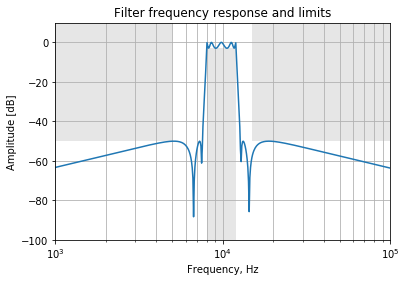

In [503]:
b, a = system_bp
w, h = signal.freqs(b, a, 2000) # Compute frequency response of analog filter
plt.semilogx(w/(2*np.pi), 20 * np.log10(abs(h)))
plt.title('Filter frequency response and limits')
plt.xlabel('Frequency, Hz')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')

plt.fill([f_lower, f_upper,  f_upper,  f_lower], [-gpass, -gpass, -100, -100], '0.9', lw=0) # passband
plt.fill([f_lower-transition, f_lower-transition, 0, 0], [-gstop, 100, 100, -gstop], '0.9', lw=0) # stopband
plt.fill([f_upper+transition, f_upper+transition, 100e9, 100e9], [-gstop, 100, 100, -gstop], '0.9', lw=0) # stopband
plt.xlim((1e3,1e5))
plt.ylim((-100,10))
plt.show()

### plot poles and zeros

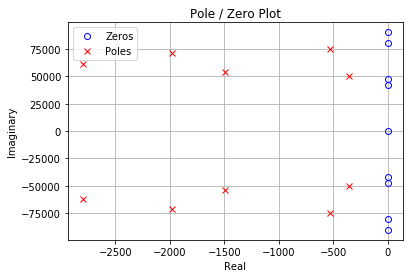

In [504]:
z, p, k = signal.tf2zpk(system_bp[0],system_bp[1])

plt.plot(np.real(z), np.imag(z), 'ob', markerfacecolor='none')
plt.plot(np.real(p), np.imag(p), 'xr')
plt.legend(['Zeros', 'Poles'], loc=2)
plt.title('Pole / Zero Plot')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.show()

### Plot the Bode magnitude and phase data
Use the SciPy function [bode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bode.html) to plot the magnitude and phase of the filter.

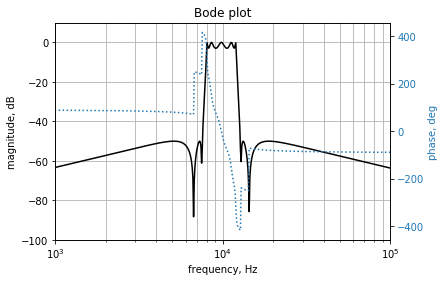

In [505]:
#x = np.linspace(10*2*np.pi, 10e3*2*np.pi, 1000, endpoint=True)
w, mag, phase = signal.bode(system_bp, w=w)

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-k')    # Bode magnitude plot

ax1.tick_params(axis='y')
plt.grid(which='both', axis='both')

ax1.set_xlim((1e3,1e5))
ax1.set_ylim((-100,10))

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(w/(2*np.pi), phase,':',color=color)  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-100,10))

plt.title('Bode plot')
plt.show()

### Plot the impulse and step response
Use the SciPy functions [impulse2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.impulse2.html) and [step2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.step2.html) to plot the impulse and step response of the system.

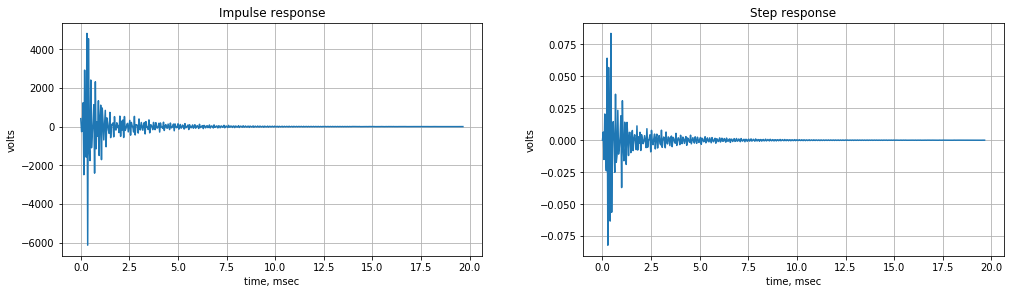

In [506]:
# figsize() function to adjust the size
plt.subplots(figsize=(15, 5))

# using subplot function and creating
# plot one
plt.subplot(1, 2, 1)

# impulse response
t, y = signal.impulse2(system_bp,N=500)
plt.plot(t/1e-3, y)
plt.title('Impulse response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# using subplot function and creating plot two
plt.subplot(1, 2, 2)

t, y = signal.step2(system_bp,N=500)
plt.plot(t/1e-3, y)
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# space between the plots
plt.tight_layout(4)

# show plot
plt.show()

#### Plot the group delay.
The following python code calculates and plots [group delay](https://en.wikipedia.org/wiki/Group_delay_and_phase_delay#). Frequency components of a signal are delayed when passed through a circuit and the signal delay will be different for the various frequencies unless the circuit has the property of being linear phase. The delay variation means that signals consisting of multiple frequency components will suffer distortion because these components are not delayed by the same amount of time at the output of the device.

Group delay: $\tau _{g}(\omega )=-\frac  {d\phi (\omega )}{d\omega }$

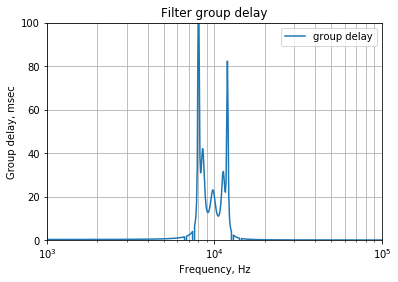

In [507]:
plt.title('Filter group delay')
plt.semilogx(w/(2*np.pi), -np.gradient(phase)/np.gradient(w)/1e-3,'-',label='group delay')
#plt.semilogx(w/(2*np.pi), -np.gradient(phase)/w/1e-3,'-',label='phase delay')
plt.xlim((1e3,100e3))
plt.ylim((0,100))

plt.ylabel('Group delay, msec')
plt.xlabel('Frequency, Hz')
plt.legend()
plt.grid(which='both', axis='both')
plt.show()

## Bandstop filter specification
Using the same filter order selection function above, set the passband frequency range as a two element array of band edge frequencies. Set the stopband frequencies as a two element array of band edge frequencies.

In [508]:
f_lower = 8e3 # lower passband edge frequency, Hz
f_upper = 10e3 # upper passband edge frequency, Hz

wp = [f_lower*2*np.pi,f_upper*2*np.pi] # passband edge frequency, Hz
gpass = 1 # The maximum loss in the passband (dB)

transition = 1e3 # amount of transition allowed
ws = [(f_lower-transition)*2*np.pi,(f_upper+transition)*2*np.pi] # stopband edge frequency, Hz
gstop = 60 # The minimum attenuation in the stopband (dB)

# uncomment filter type to use
#N, Wn = signal.buttord(wp, ws, gpass, gstop,analog=True)
#N, Wn = signal.cheb1ord(wp, ws, gpass, gstop,analog=True)
#N, Wn = signal.cheb2ord(wp, ws, gpass, gstop,analog=True)
N, Wn = signal.ellipord(wp, ws, gpass, gstop,analog=True)

print('order = {:.0f}'.format(N))

order = 5


In [509]:
#system_bs = signal.butter(N, [f_lower*(2*np.pi),f_upper*(2*np.pi)], btype='bandstop', output='ba', analog=True)
#system_bs = signal.cheby1(N, gpass, [f_lower*(2*np.pi),f_upper*(2*np.pi)], btype='bandstop', output='ba', analog=True)
#system_bs = signal.cheby2(N, gstop, [f_lower*(2*np.pi),f_upper*(2*np.pi)], btype='bandstop', output='ba', analog=True)
system_bs = signal.ellip(N, gpass, gstop, [f_lower*(2*np.pi),f_upper*(2*np.pi)], btype='bandstop', output='ba', analog=True)
#system_bs = signal.bessel(N, [f_lower*(2*np.pi),f_upper*(2*np.pi)], btype='bandstop', output='ba', analog=True, norm='mag')

### plot filter specification limits
The grey areas are the keep out areas specified above.

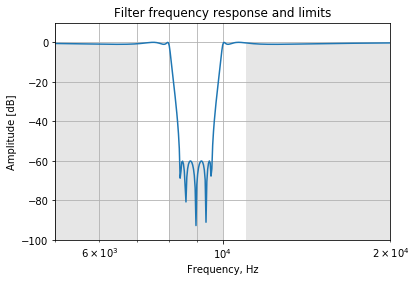

In [510]:
b, a = system_bs
w, h = signal.freqs(b, a, 2000) # Compute frequency response of analog filter
plt.semilogx(w/(2*np.pi), 20 * np.log10(abs(h)))
plt.title('Filter frequency response and limits')
plt.xlabel('Frequency, Hz')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')

plt.fill([f_lower, f_upper,  f_upper,  f_lower], [-gstop, -gstop, -100, -100], '0.9', lw=0) # passband
plt.fill([f_lower-transition, f_lower-transition, 0, 0], [-gpass, -100, -100, -gpass], '0.9', lw=0) # stopband
plt.fill([f_upper+transition, f_upper+transition, 100e9, 100e9], [-gpass, -100, -100, -gpass], '0.9', lw=0) # stopband
plt.xlim((5e3,2e4))
plt.ylim((-100,10))
plt.show()

### plot poles and zeros

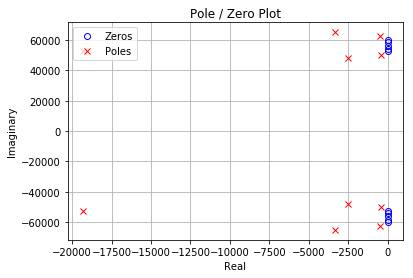

In [511]:
z, p, k = signal.tf2zpk(system_bs[0],system_bs[1])

plt.plot(np.real(z), np.imag(z), 'ob', markerfacecolor='none')
plt.plot(np.real(p), np.imag(p), 'xr')
plt.legend(['Zeros', 'Poles'], loc=2)
plt.title('Pole / Zero Plot')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.show()

### Plot the Bode magnitude and phase data
Use the SciPy function [bode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bode.html) to plot the magnitude and phase of the filter.

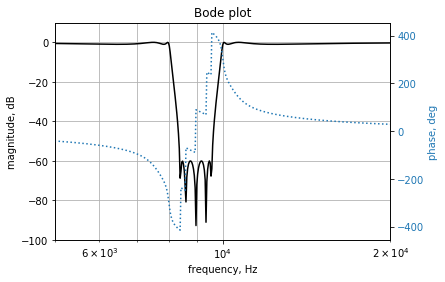

In [512]:
#x = np.linspace(10*2*np.pi, 10e3*2*np.pi, 1000, endpoint=True)
w, mag, phase = signal.bode(system_bs, w=w)

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-k')    # Bode magnitude plot

ax1.tick_params(axis='y')
plt.grid(which='both', axis='both')

ax1.set_xlim((5e3,2e4))
ax1.set_ylim((-100,10))

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(w/(2*np.pi), phase,':',color=color)  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Bode plot')
plt.show()

### Plot the impulse and step response
Use the SciPy functions [impulse2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.impulse2.html) and [step2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.step2.html) to plot the impulse and step response of the system.

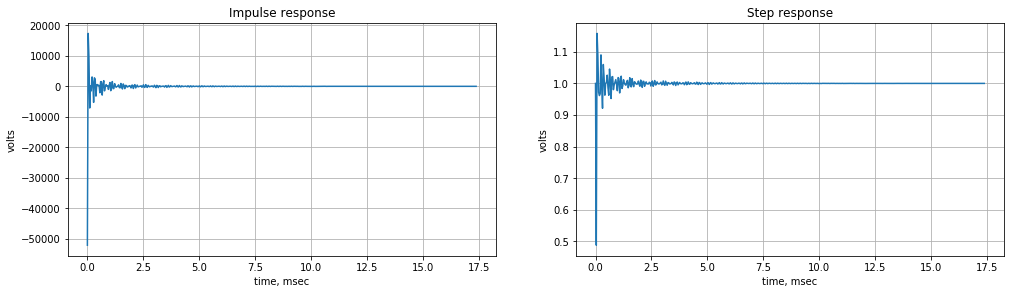

In [513]:
# figsize() function to adjust the size
plt.subplots(figsize=(15, 5))

# using subplot function and creating
# plot one
plt.subplot(1, 2, 1)

# impulse response
t, y = signal.impulse2(system_bs,N=500)
plt.plot(t/1e-3, y)
plt.title('Impulse response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# using subplot function and creating plot two
plt.subplot(1, 2, 2)

t, y = signal.step2(system_bs,N=500)
plt.plot(t/1e-3, y)
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# space between the plots
plt.tight_layout(4)

# show plot
plt.show()

#### Plot the group delay.
The following python code calculates and plots [group delay](https://en.wikipedia.org/wiki/Group_delay_and_phase_delay#). Frequency components of a signal are delayed when passed through a circuit and the signal delay will be different for the various frequencies unless the circuit has the property of being linear phase. The delay variation means that signals consisting of multiple frequency components will suffer distortion because these components are not delayed by the same amount of time at the output of the device.

Group delay: $\tau _{g}(\omega )=-\frac  {d\phi (\omega )}{d\omega }$

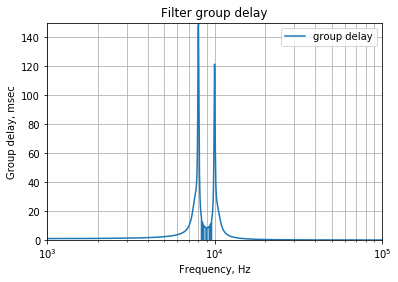

In [514]:
plt.title('Filter group delay')
plt.semilogx(w/(2*np.pi), -np.gradient(phase)/np.gradient(w)/1e-3,'-',label='group delay')
#plt.semilogx(w/(2*np.pi), -np.gradient(phase)/w/1e-3,'-',label='phase delay')
plt.ylabel('Group delay, msec')
plt.xlabel('Frequency, Hz')
plt.xlim((1e3,100e3))
plt.ylim((0,150))
plt.legend()
plt.grid(which='both', axis='both')
plt.show()

## Bessel Lowpass filter
SciPy doesn't have an order calculation function for the bessel type filter, so I'll just pick a filter order and cut off frequency and plot the results. The analog Bessel filter has maximally flat group delay and maximally linear phase response, with very little ringing in the step response.

### Find filter coefficients
The functions return the numerator (b) and denominator (a), polynomials. Critical frequency normalization parameter is set to norm = 'mag', so that the gain magnitude is -3 dB at angular frequency Wn.

In [515]:
fp = 10e3 # passband edge frequency, Hz
N = 5
Wn = fp*2*np.pi
system_lp = signal.bessel(N, Wn, btype='lowpass', output='ba', analog=True, norm='mag')

### Plot the Bode magnitude and phase data
Use the SciPy function [bode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bode.html) to plot the magnitude and phase of the filter.

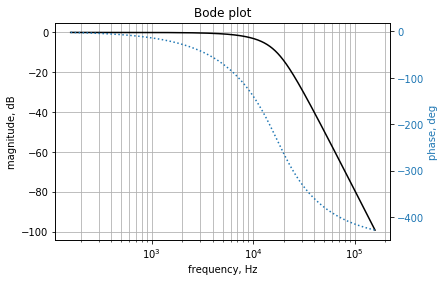

In [516]:
w, mag, phase = signal.bode(system_lp, w=w)

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-k')    # Bode magnitude plot

ax1.tick_params(axis='y')
plt.grid(which='both', axis='both')

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(w/(2*np.pi), phase,':',color=color)  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Bode plot')
plt.show()

### plot poles and zeros

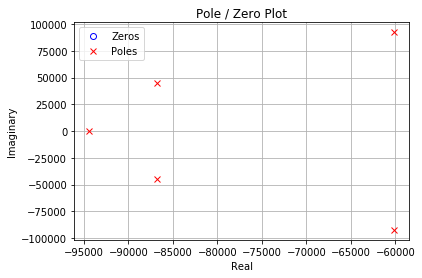

k = 10980315993618949271977984.0


In [517]:
z, p, k = signal.tf2zpk(system_lp[0],system_lp[1])

plt.plot(np.real(z), np.imag(z), 'ob', markerfacecolor='none')
plt.plot(np.real(p), np.imag(p), 'xr')
plt.legend(['Zeros', 'Poles'], loc=2)
plt.title('Pole / Zero Plot')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.show()
print('k = {:.1f}'.format(k))

### Plot the impulse and step response
Use the SciPy functions [impulse2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.impulse2.html) and [step2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.step2.html) to plot the impulse and step response of the system.

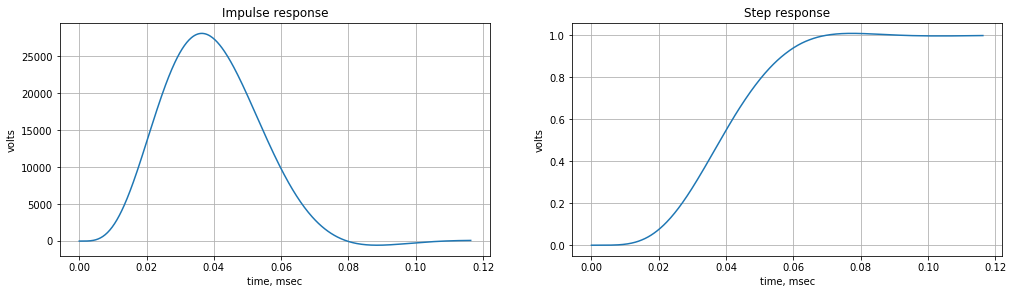

In [518]:
# figsize() function to adjust the size
plt.subplots(figsize=(15, 5))

# using subplot function and creating
# plot one
plt.subplot(1, 2, 1)

# impulse response
t, y = signal.impulse2(system_lp,N=500)
plt.plot(t/1e-3, y)
plt.title('Impulse response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# using subplot function and creating plot two
plt.subplot(1, 2, 2)

t, y = signal.step2(system_lp,N=500)
plt.plot(t/1e-3, y)
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# space between the plots
plt.tight_layout(4)

# show plot
plt.show()

#### Plot the group delay.
The following python code calculates and plots [group delay](https://en.wikipedia.org/wiki/Group_delay_and_phase_delay#). Frequency components of a signal are delayed when passed through a circuit and the signal delay will be different for the various frequencies unless the circuit has the property of being linear phase. The delay variation means that signals consisting of multiple frequency components will suffer distortion because these components are not delayed by the same amount of time at the output of the device.

Group delay: $\tau _{g}(\omega )=-\frac  {d\phi (\omega )}{d\omega }$

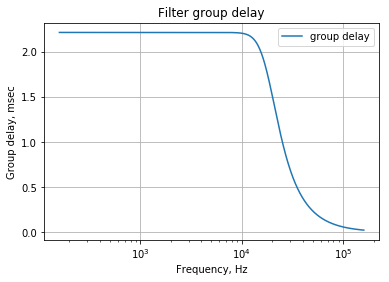

In [519]:
plt.title('Filter group delay')
plt.semilogx(w/(2*np.pi), -np.gradient(phase)/np.gradient(w)/1e-3,'-',label='group delay')
#plt.semilogx(w/(2*np.pi), -np.gradient(phase)/w/1e-3,'-',label='phase delay')
plt.ylabel('Group delay, msec')
plt.xlabel('Frequency, Hz')
#plt.ylim((0,20))
plt.legend()
plt.grid()
plt.show()

The group delay graph shows that the delay through the filter is constant for frequencies below 10kHz. 

## Filter synthesis example
The following example walks through the filter design steps for a low pass filter using the SciPy analog filter functions. Specifictions for the filter are determined and the order of the filter is calculated. The type of filter selected for implementation is a passive Butterworth filter implemented with capacitors and inductors in a ladder topology. At this point in the design process, filter design tables are used and the normalized element values for a ladder topology are obtained. In this example. I'm going to calculate the normalized values using partial fraction decomposition following the Cauer method. 

### Filter specification
The following filter specifictions are derived from the system requirments. The engineer has determined that a low pass filter is needed and that a passive filter using capacitors and inductors with Butterworth characteristics will meet the system requirements and design goals.

Required: Design a low pass filter meeting the following specifications:  
- Low pass Butterworth filter, implemented with inductors and capacitors 
- 3dB attenuation frequency of 1kHz
- 20dB minimum stop band attenuation at 2kHz
- $R_{source}$ = $R_{load}$ = 1000 ohms

Using the Butterworth filter order selection function, determine the order of the filter required.

In [520]:
fp = 1e3 # passband edge frequency, Hz
gpass = 3 # The maximum loss in the passband (dB)

fs = 2e3 # stopband edge frequency, Hz
gstop = 20 # The minimum attenuation in the stopband (dB)

# uncomment filter type to use
order, Wn = signal.buttord(fp*2*np.pi, fs*2*np.pi, gpass, gstop,analog=True)

print('order = {:.0f}, -3dB cut off frequency = {:.2f} Hz'.format(order,Wn/(2*np.pi)))

order = 4, -3dB cut off frequency = 1000.59 Hz


The filter order meeting the attenuation requirments is 4.

### Plot the Bode magnitude and phase data
Use the SciPy function [bode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bode.html) to plot the magnitude and phase of the filter. The grey areas are the keep out areas specified above.

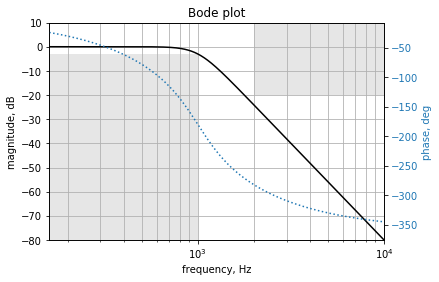

In [521]:
system_lp = signal.butter(order, Wn, btype='lowpass', output='ba', analog=True)

w, mag, phase = signal.bode(system_lp, w=w)

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-k')    # Bode magnitude plot

ax1.tick_params(axis='y')
plt.grid(which='both', axis='both')

plt.fill([0, fp,  fp,  0], [-gpass, -gpass, -100, -100], '0.9', lw=0) # passband
plt.fill([fs, fs, 100e9, 100e9], [-gstop, 100, 100, -gstop], '0.9', lw=0) # stopband
plt.xlim((w[0]/(2*np.pi),10e3))
plt.ylim((-80,10))


# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(w/(2*np.pi), phase,':',color=color)  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Bode plot')
plt.show()

The plot above shows that a 4th order filter will meet the filter design requirments. 

### Sythesis of filters from polynominals
Filter design tables contain tables of transfer functions and the component values, so that design by synthesis is not the usual design method. However, in this example, I'm going to walk through the synthesis of the filter from the polynominal. One method of synthesis is to expand the driving point impedance. If the transfer function is all poles, the expression for $Z_{11}$ is:  
$Z_{11} = \frac {D(s)-s^n}{D(s)+s^n}$  
where  
D(s) is the demoninator of the transfer function.

The expansion involves successive division and inversion of the ratio of the two polynominals. The final form contains a sequence of terms that are the values for the capacitors and inductors. 

Butterworth, cheby1 and bessel have poles only, so the expression for $Z_{11}$ given above can be used.

Using the SciPy function butter, calculate the numerator and denominator of the transfer function.

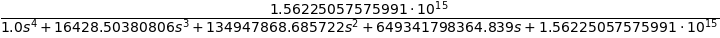

In [522]:
num, den = signal.butter(order, Wn, btype='lowpass', output='ba', analog=True)

s = symbols('s') # declare the variable s

# transfer function
Poly(num, s)/Poly(den, s)

The transfer function contains terms that have large exponents, i.e. $10^{15}$. Continuing with the calculations, these terms present a problem in the numberical calculations. The expression for $Z_{11}$ is shown below.

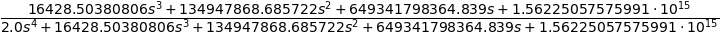

In [523]:
Z11 = (Poly(den, s)-s**order)/(Poly(den, s)+s**order)
Z11

The filter is realized with the [Cauer procedure](https://en.wikipedia.org/wiki/Network_synthesis#Cauer_synthesis). This involves removal of poles and zeros from the Z(s) and Y(s) functions in a continued fraction expansion. The SymPy function [apart()](https://docs.sympy.org/latest/tutorials/intro-tutorial/simplification.html#apart) can be employed to remove the poles at s=0 for $Z_{11}$.

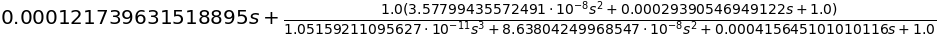

In [524]:
apart(1/Z11)

The term, $0.000121739631518895s$ , is the first element value in the filter, with the source resistance of 1 ohm. The value will need to be impedance scaled in the final design. Removing $0.000121739631518895s$ from the expression by subtracting it, we get the following result.

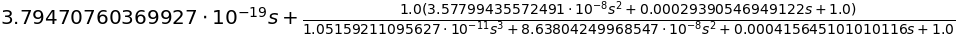

In [525]:
apart(1/Z11) - 0.000121739631518895*s

Here is where we run into a problem with the calculations. There are terms in the result that have small exponents. e.g. $10^{-19}$ and for these terms it is not easy to determine whether, these are actually zero or should be carried along in subsequent steps.  To avoid this difficulty, the filter natural frequency is normimalized to 1 rad/s, which avoids large exponents in the coefficients of the filter polynominal.

Re-calculate the numerator and denominator polynomials with the normalized frequency of 1 rad/s.

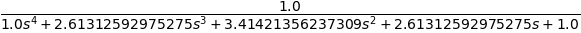

In [526]:
order = 4
Wn = 1
num, den = signal.butter(order, Wn, btype='lowpass', output='ba', analog=True)

Poly(num, s)/Poly(den, s)

Now the driving point impedance for the filter can be written.

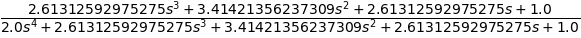

In [527]:
Z11 = (Poly(den, s)-s**order)/(Poly(den, s)+s**order)
Z11

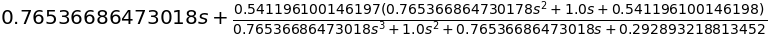

In [528]:
apart(1/Z11)

The first value is 0.76536686473018*s, which we can save in an array called normalized_values

In [529]:
normalized_values = np.zeros(order)
normalized_values[0] = 0.76536686473018

Now remove the term $0.76536686473018s$ by subtracting it, we get:

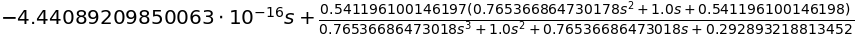

In [530]:
Za = apart(1/Z11) - 0.76536686473018*s
Za

Unfortunately, Sympy numerical evaluation can't tell an expression that is exactly zero apart from one that is merely very small. Using chop=True doesn't help. I also tried .evalf(20) to get more digits displayed, then tried chop=True, and these still left small values that interfered with the next step.

The work around is to copy the terms needed by hand into the next step.

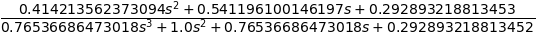

In [531]:
# don't copy the small values
Za = 0.541196100146197*(0.765366864730178*s**2 + 1.0*s + 0.541196100146198)/(0.76536686473018*s**3 + 1.0*s**2 + 0.76536686473018*s + 0.292893218813452)
Za

Continuing with the partial fractin expansion.

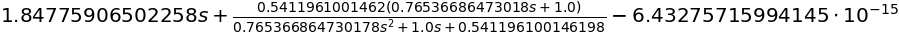

In [532]:
apart(1/Za)

Next value is 1.84775906502258*s, copying the remainder by hand, leaving out small numbers

In [533]:
normalized_values[1] = 1.84775906502258

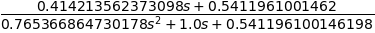

In [534]:
Zb = 0.5411961001462*(0.76536686473018*s + 1.0)/(0.765366864730178*s**2 + 1.0*s + 0.541196100146198)
Zb

In [535]:
apart(1/Zb)

The next value is 1.84775906502256*s, copying the remainder by hand, leaving out small numbers

In [536]:
normalized_values[2] = 1.84775906502256

In [537]:
Zc = 0.99999999999999/(0.76536686473018*s + 1.0)
Zc

In [538]:
apart(1/Zc)

In [539]:
normalized_values[3] = 0.765366864730188

Normalized 4th order values are:

In [540]:
normalized_values

array([0.76536686, 1.84775907, 1.84775907, 0.76536686])

These values agree with the values in Table 11-2 of [2].

### Frequency and impedance scaling
Now scale to correct frequency and source resistor value.

Frequency scaling factor (FSF)  

$FSF =  \frac {desired frequency}{normalized frequency} \text{ (in rad/s)}$

Diving all reactive elements by FSF

Impedance scaling factor  
$R' = Z \times R$  
$L' = \frac {Z \times L}{FSF}$  
$C' = \frac {C}{Z \times FSF}$  

primes are values after scaling

In [541]:
FSF = fp*2*np.pi
Z = 1000

# shunt C
C1 = normalized_values[0]/(Z*FSF)
print('C1 = {:.1f} nF'.format(C1/1e-9))
# series L
L1 = Z*normalized_values[1]/FSF
print('L1 = {:.1f} mH'.format(L1/1e-3))
# shunt C
C2 = normalized_values[2]/(Z*FSF)
print('C2 = {:.1f} nF'.format(C2/1e-9))
# series L
L2 = Z*normalized_values[3]/FSF
print('L2 = {:.1f} mH'.format(L2/1e-3))

C1 = 121.8 nF
L1 = 294.1 mH
C2 = 294.1 nF
L2 = 121.8 mH


### LTspice simulation results  
A schematic of the filter was drawn in LTspice and the AC frequency responce was simulated. 

<img src="Schematic_lpf.png" width="500">  

The plot below agrees with the Bode plot obtained from SciPy.

<img src="lpf_plot.png" width="500">  
